In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

data = pd.read_csv("data/total_data.csv", index_col=0)

NUM_NON_TURN_COLS = 21

In [28]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 111369 entries, 0 to 111368
Data columns (total 75 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   RoundNumber    111369 non-null  float64
 1   Location       111369 non-null  object 
 2   Session        111369 non-null  object 
 3   Year           111369 non-null  float64
 4   Driver         111369 non-null  object 
 5   Compound       111369 non-null  object 
 6   TyreLife       111369 non-null  float64
 7   FreshTyre      111369 non-null  bool   
 8   TrackStatus    111369 non-null  int64  
 9   LapTime        111369 non-null  object 
 10  AirTemp        111369 non-null  float64
 11  Humidity       111369 non-null  float64
 12  Pressure       111369 non-null  float64
 13  Rainfall       111369 non-null  bool   
 14  TrackTemp      111369 non-null  float64
 15  WindDirection  111369 non-null  int64  
 16  WindSpeed      111369 non-null  float64
 17  TrackLength    111369 non-null  fl

In order to perform proper feature selection and extraction, and as it is required for a regression model, I converted the target variable (Laptime) into a `float64` value, to allow for proper graphical and correlation analysis. 

In [29]:
data['LapTime'] = data['LapTime'].apply(lambda x: pd.to_timedelta(x).total_seconds())

<Axes: xlabel='LapTime', ylabel='Count'>

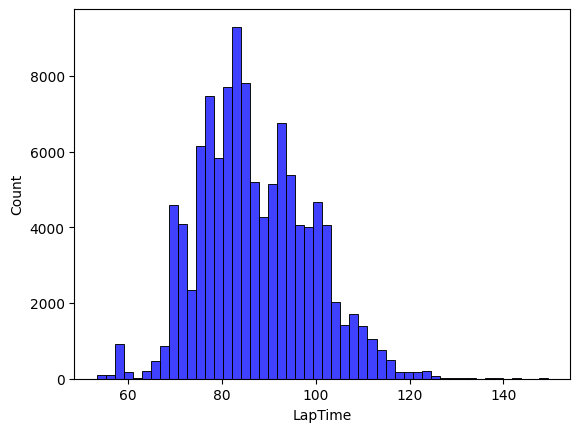

In [30]:
# Looking at the spread of laptimes in the data
sns.histplot(data['LapTime'], color='b', bins=50)

There seems to be a right skew in the data with a few laps having a laptime greater than 2 minutes. This may be due to laps in wet conditions around longer tracks like Spa-Francorchamps, but this will need to be analysed further. 

Let us first analyse the categorical variables in this feature set, which are:
- Compound
- Session
- FreshTyre
- Rainfall
- Track Status

Let us now analyse the correlations between each of these variables and the laptime. 

In [31]:
def boxplot(df, feature, order=None):
    sns.boxplot(df, x=feature, y='LapTime', order=order)

    plt.title(f"{feature} vs. Laptime")
    plt.ylabel("Laptime (s)")
    plt.xticks(rotation=45)
    plt.show()

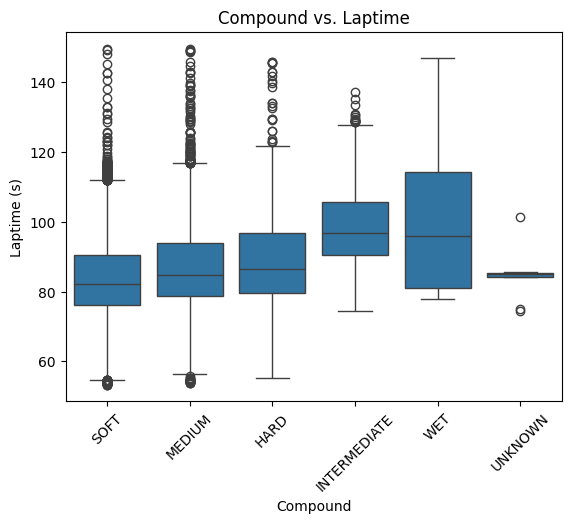

Compound
HARD            145.672
INTERMEDIATE    137.012
MEDIUM          149.321
SOFT            149.461
UNKNOWN         101.230
WET             146.648
Name: LapTime, dtype: float64
(10, 75)


In [32]:
# Analysing the impact of different compounds on laptimes 

compound_order = ['SOFT', 'MEDIUM', 'HARD', 'INTERMEDIATE', 'WET', 'UNKNOWN']

boxplot(data, "Compound", compound_order)

print(data.groupby('Compound')['LapTime'].max())

print(data[data['Compound'] == 'UNKNOWN'].shape)

The results of the boxplot clearly indicate that as we move through the `compound_order` specified, there is a positive correlation with laptime (i.e., laptimes increase). Additionally, the data shows that there are some laps for which the tyre choice is `UNKNOWN`, which can simply be removed, as there are only 10 such records, and they will not disrupt the variety of data available whatsoever. 

The high outliers in this data, particularly for the `SOFT` and `MEDIUM` compounds can be investigated further, particularly the fact that the maximum laptimes on all the dry tyres exceed 2:20:000. This could indicate that our data contains outlier laps where there was rainfall or drivers had damage, and needs to be studied further. Due to high variability and generally much slower laptimes in the wet, we can see much fewer outliers, even though laptimes in the wet also exceed roughly `2:10:000` at times. 

To analyse this further, let us take the look at the number of laptimes on each dry tyre that exceed 2 minutes. This upper bound of 2 minutes has been taken as it is slightly higher than the average laptime near the start of a race around Spa-Francorchamps (the longest F1 track between 2020-24), which is around `1:50:000-1:53:000`.

In [33]:
data = data[~(data['Compound'] == 'UNKNOWN')]

In [34]:
dry_tyres = ['SOFT', 'MEDIUM', 'HARD']
wet_tyres = ['INTERMEDIATE', 'WET']

outlier_data = data[(data['Compound'].isin(dry_tyres)) & (data['LapTime'] >= 120.0)].iloc[ : , : 22]
outlier_data[outlier_data['Rainfall']].shape

num_outlier_data = outlier_data.select_dtypes(include=[np.number])
num_outlier_data.corr()['LapTime'].sort_values(ascending=False)

LapTime          1.000000
WindDirection    0.291492
TrackLength      0.241823
Turn1X           0.184231
NumCorners       0.162818
TrackTemp        0.153964
WindSpeed        0.075423
AirTemp          0.055557
TrackStatus      0.045067
NumDrs           0.031249
RoundNumber     -0.028074
Year            -0.028668
Pressure        -0.059948
Humidity        -0.160587
TyreLife        -0.202115
TrackRotation   -0.287328
Name: LapTime, dtype: float64

In total, there are `112` lap records with dry tyres that exceed 2 minutes. Out of these, only `5` laps occurred during rain, indicating that driving on slicks during the rain is not a key reason for these abnormal laptimes. Moreover, when analysing the correlation between these high laptimes and other features of the dataset, there is no significant correlation between any of the other factors (E.g., wind speed, track temperature etc.) and these laptimes. 

This likely indicates that other features, such as damage to the car, is a likely cause of these laptimes. As there are only `112` such laps, which is roughly `0.9%` of the dataset, and they are clearly outliers, we can safely remove these records. 

In [35]:
data = data[~((data['Compound'].isin(dry_tyres)) & (data['LapTime'] > 120.0))]

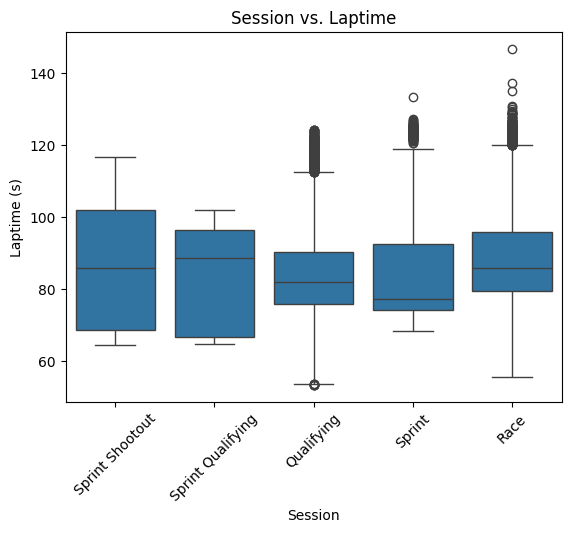

In [36]:
# Analysing the correlation between different sessions and the laptime.

session_order = ['Sprint Shootout', 'Sprint Qualifying', 'Qualifying', 'Sprint', 'Race']

boxplot(data, "Session", session_order)


Though the data here evidently shows that on average, qualifying sessions have faster laptimes than race sessions (as expected), we also see that the average laptimes for all sprint sessions (quali/shootout/race) are higher than regular sessions.

This is most likely due to the fact that there are very limited tracks at which Sprints are held, with only 17 Sprint weekends since 2021, when they were introduced. Additionally, there are only a few tracks where Sprints have been held, such as Interlagos, Monza, Spielberg, Qatar etc., some of which may be longer than the average track on the F1 calendar. Due to this smaller variety of data and tracks, the average laptime for sprint sessions is higher. 

Thus, to get a proper comparison between Sprint & Grand Prix (GP) qualifying/races, we need to:
1. Get all of the Sprint events since 2021 (location + year)
2. Analyse the boxplots of the laptimes for Sprint sessions and GP sessions for each of those tracks

Moreover, to get a more fair comparison, we will compare the Sprint vs. GP sessions for each type of Sprint session separately. This is as events such as Sprint Shootouts were replaced by Sprint Qualifying, so it is more accurate to compare Sprint shootout laptimes only with the GP qualifying lap times during the same weekend. 

If we still see a variation in the spread and quartiles between sprint & GP sessions, then there is likely a correlation between the driver's laptime and the session.

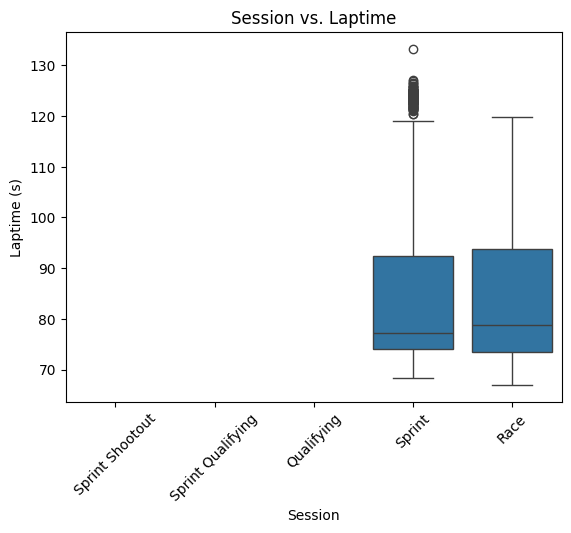

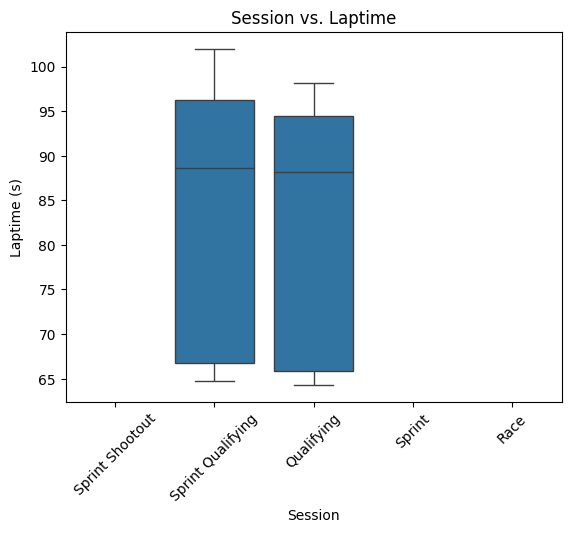

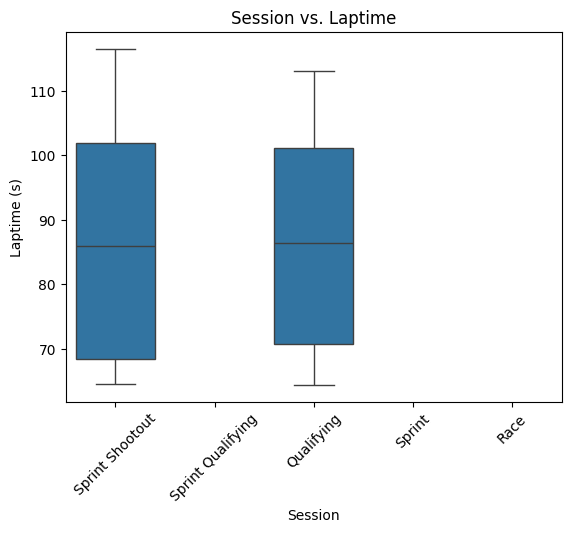

In [37]:
# Separately collating the tracks where sprint qualifying, sprint shootouts, and sprint races were held
sprint_sessions = data[data['Session'] == 'Sprint']
sprint_quali_sessions = data[data['Session'] == 'Sprint Qualifying']
sprint_shootout_sessions = data[data['Session'] == 'Sprint Shootout']

# Given a dataframe containing data for a certain sprint session (E.g., sprint shootout):
# 1. Identify all the unique events where sprint shootouts were held (Location + Year)
# 2. Get data of all the (session_type = ) Qualifying sessions (or Race sessions in case we take a 'Sprint' race session) held during the same event. 
def get_sessions_from_sprint_type(df, session_type):
    races_on_sprint_track_list = []

    for _, row in df.drop_duplicates(subset=['Location', 'Year']).iterrows():
        races_on_sprint_track_list.append(data[
            (data['Location'] == row['Location']) & 
            (data['Year'] == row['Year']) & 
            (data['Session'] == session_type)
            ])
    
    return pd.concat([df, pd.concat(races_on_sprint_track_list)])

all_data = [get_sessions_from_sprint_type(sprint_sessions, "Race"), 
            get_sessions_from_sprint_type(sprint_quali_sessions, "Qualifying"), 
            get_sessions_from_sprint_type(sprint_shootout_sessions, "Qualifying")
            ]

for df in all_data:
    boxplot(df, "Session", session_order)



This data gives us a much better comparison between Sprint sessions and their respective Grand Prix counterparts. In all of the boxplots, the quartiles and distribution of the data are almost identical, indicating that though there is a clear contrast between qualifying and race laptimes, there is no major difference between Sprint vs. Race sessions. 

One notable difference is that the Sprint Qualifying and Sprint Shootout sessions have a higher upper bound on laptimes as compared to the Grand Prix Qualifying session. However, this can easily be explained by the fact that out of the 3 mini-sessions in any qualifying event, Sprint qualifying/shootout sessions have 2 mini-sessions wherein drivers are mandated to use `MEDIUM` tyres. As determined above, `MEDIUM` tyres generally have longer laptimes than `SOFT` tyres (typically used throughout all GP Qualifying mini-sessions), which can contribute to this right tail of the data. 

However, overall, based on the findings, we can generally say that any Grand Prix weekend can have its laptimes split based on 2 major sessions, 'Qualifying and 'Race'. Thus, we can regroup all of the sessions under these two major headers, as any other sub-divisions have no major impact on the laptimes of drivers.

In [38]:
# Regrouping all of the Sessions data of drivers into 'Qualifying' and 'Race'.
import re 

print(data['Session'].unique())

def map_session_names(name):
    if re.search(r'Qualifying|Shootout', name, re.IGNORECASE): 
        return 'Qualifying'
    
    return 'Race'

data['Session'] = data['Session'].apply(map_session_names)
data['Session'].unique()

['Qualifying' 'Race' 'Sprint' 'Sprint Shootout' 'Sprint Qualifying']


array(['Qualifying', 'Race'], dtype=object)

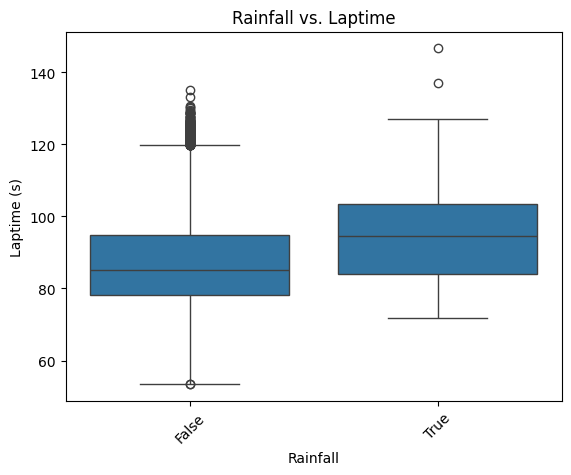

97.26% of the data is for laps with no rainfall.


In [39]:
# Analysing the correlation between rainfall and laptime.

boxplot(data, "Rainfall")

print("{:.2f}% of the data is for laps with no rainfall.".format(len(data[~data['Rainfall']]) / len(data) * 100))


Though there are several outliers in the data for `rainfall = False`, it is obviously visible that no rainfall contributes to faster laptimes. Thus, this is a significant feature which should be preserved. 

Moreover, over `97.26%` of the data is for laps without rainfall. As a result, the greater variety in tracks, years, and overall number of laps could contribute heavily to the greater spread of data for laps without rainfall. 

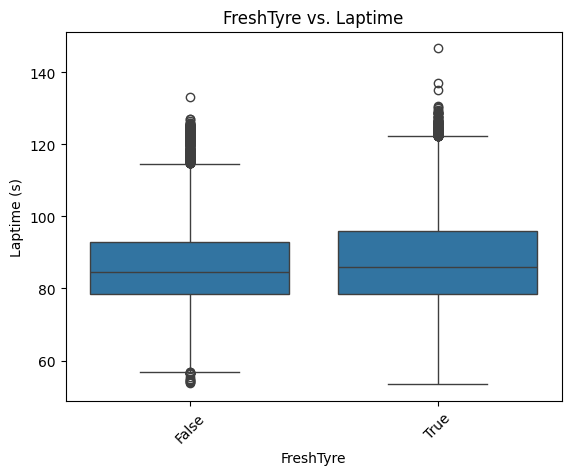

Correlation coefficient: 0.10812877639159149, p-value: 1.7627353723264427e-286


In [40]:
# Analysing the correlation between fresh tyres and laptime.
from scipy import stats

boxplot(data, "FreshTyre")

# Using Point-Biserial Correlation coefficient to determine correlation between rainfall (binary feature) and lap time (continuous output)
correlation, p_value = stats.pointbiserialr(data['Rainfall'], data['LapTime'])
print(f"Correlation coefficient: {correlation}, p-value: {p_value}")


Based on these results, the almost negligible p-value does indicate that the tyres being fresh does statistically affect the laptime. However, based on distribution of data from the boxplot, and the low correlation coefficient value of `0.108`, this correlation is extremely weak, and it is not major enough to be considered further. Thus, this a feature that may be removed from our feature set. 

While this result was initially surprising, given that newer tyres are typically considered "better", it should be noted that "new" tyres typically take 1-2 laps to heat up to their optimal temperature window. Thus, newer tyres, though fresh & grippy, may be too cold to provide optimal laptimes, and the variability between these factors may contribute to this spread of data for `FreshTyre = True`. 

In [41]:
data.drop("FreshTyre", axis=1, inplace=True)

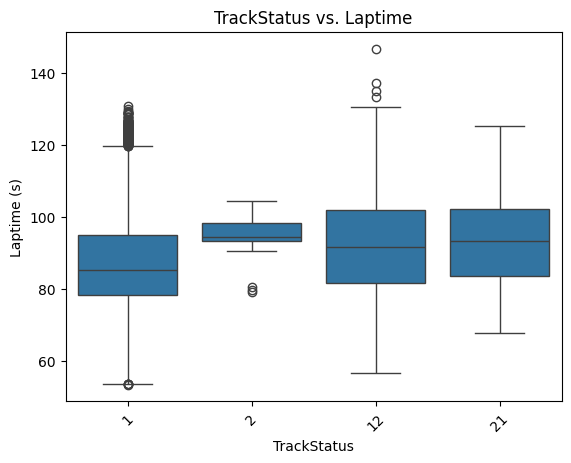

Number of records containing track status 2 is 3.40%


In [42]:
# Analysing the correlation between the track status and laptimes.

boxplot(data, "TrackStatus")

print("Number of records containing track status 2 is {:.2f}%".format(len(data[data['TrackStatus'] > 1]) / len(data) * 100))

Here, we have `4` unique track status codes - `1`, `2`, `12`, and `21`. All of the status codes containing `2` indicate that there was a yellow flag at some point in the driver's lap (ref: https://docs.fastf1.dev/api.html#fastf1.api.track_status_data). We do not wish to include such records in our data, as drivers have to slow down under yellow flags, and thus we do not get representative laptimes. 

Thus, we will drop all of the track status records containing status '2'. This only accounts for 3.40% of all the data, and thus can safely be done without impacting the dataset too much. Following this, as we only have one possible value for the TrackStatus feature, i.e., 1, it does not contribute to the laptime at all, and can thus be removed as a feature. 

In [43]:
data = data[data['TrackStatus'] == 1]
data.drop("TrackStatus", axis=1, inplace=True)

Let us now analyse the numerical features of this dataset:

In [44]:
# Analysing the Pearson correlation matrix of all numerical variables to identify any potential linear relations with laptime.
num_data = data.select_dtypes(include=[np.number]).drop(["RoundNumber", "Year"], axis=1)
num_data.corr()['LapTime'].nlargest(10)


LapTime          1.000000
TrackLength      0.750763
NumCorners       0.526101
Turn2X           0.313278
Pressure         0.255080
Turn3X           0.251369
Turn1Y           0.241534
Turn1X           0.240059
TrackRotation    0.183436
Turn21Y          0.155505
Name: LapTime, dtype: float64

The correlation data reveals that the most strongly linearly correlated features for laptime in our dataset (excluding turns) are:
 - Track length (0.751)
 - Number of corners (0.526)
 - Air Pressure (0.255)

Given the higher correlation coefficients of these features, we can undoubtedly say that they should be preserved in our input feature set. 

Apart from these features, certain features such as `Turn2X` and `Turn3X` were also identified to be moderately correlated, but this needs to be studied further, as individual x-coordinates are meaningless in the context of a lap around a track. 

As for our remaining numerical inputs, we will process them as is right now, and will use recursive feature elimination later on to identify the most relevant features. 

Let us now create a preprocessor for our data.

In [45]:
X = data.drop("LapTime", axis=1)
y = data[['LapTime']]

X.drop(['Location', 'Year', 'Driver', 'RoundNumber'], axis=1, inplace=True)


In [50]:
from sklearn.model_selection import train_test_split

train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.3, random_state=1)

In [51]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, Binarizer

num_data = X.select_dtypes(include=[np.number]).columns 
cat_data = X.select_dtypes(include=[object]).columns 

compound_order = ['SOFT', 'MEDIUM', 'HARD', 'INTERMEDIATE', 'WET']
session_order = ['Qualifying', 'Race']
rain_order = ['False', 'True']

scaler = StandardScaler()
c_encoder = OrdinalEncoder(categories=[compound_order])
s_encoder = OrdinalEncoder(categories=[session_order])
bin_encoder = Binarizer()

preprocessor = ColumnTransformer([
    ("scaled", scaler, num_data),
    ("c_encoded", c_encoder, ["Compound"]),
    ("s_encoded", s_encoder, ["Session"]),
    ("bin_encoded", bin_encoder, ["Rainfall"]),
    ],
    remainder="drop"
)

In [53]:
p_train_X = pd.DataFrame(preprocessor.fit_transform(train_X), columns=preprocessor.get_feature_names_out(), index=train_X.index)


- Need to do some feature selection from the data
- Need to try to do feature extraction - figure out some way to make turns data work 


In [61]:
from sklearn.feature_selection import mutual_info_regression

turn_cols = [col for col in p_train_X.columns if 'Turn' in col]

new_X = p_train_X.drop(turn_cols, axis=1)
importance = mutual_info_regression(new_X, train_y)
imp_columns = list(zip(importance,(new_X.columns)))
imp_columns.sort(reverse=True)
imp_columns[:20]

/Users/angadkalra/Desktop/laptime_project/venv/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[(1.7200740974809285, 'scaled__Pressure'),
 (1.5627003920421023, 'scaled__TrackLength'),
 (1.3874510405258196, 'scaled__TrackRotation'),
 (0.9939164982167279, 'scaled__Humidity'),
 (0.9206854615490512, 'scaled__AirTemp'),
 (0.9199101761044104, 'scaled__NumCorners'),
 (0.8611205098349064, 'scaled__TrackTemp'),
 (0.4790548335229987, 'scaled__WindDirection'),
 (0.2079694020522087, 'scaled__WindSpeed'),
 (0.19034161653405413, 'scaled__NumDrs'),
 (0.09554221074958447, 'c_encoded__Compound'),
 (0.09190267431318322, 'scaled__TyreLife'),
 (0.04044689211491703, 's_encoded__Session'),
 (0.008538999110379697, 'bin_encoded__Rainfall')]

In [64]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.metrics import mean_absolute_error

model = LinearRegression()
model.fit(new_X, train_y)

p_test_X = pd.DataFrame(preprocessor.transform(test_X), columns=preprocessor.get_feature_names_out(), index=test_X.index)
p_test_X.drop(turn_cols, axis=1, inplace=True)
preds_y = model.predict(p_test_X)

mean_absolute_error(test_y, preds_y)


4.797214111581187

Changes to be made to data:
1. Remove driver, round number, and location columns 

Start analysing the numerical data - graphs of each variable vs. laptime 

For track - normalise it to make turn 1 (0,0) and rotate it along track angle